In [2]:
import xarray as xr 
import numpy as np
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import pandas as pd
import dask.array as da
import glob 
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:


cluster = SLURMCluster(
    job_name="climt1",          # --job-name
    cores=16,                     # Number of cores per task (adjust if needed)
    processes=16,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)



/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37555 instead
  warnings.warn(


In [4]:

cluster.scale(4)

client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:37555/status,
Dashboard: http://10.42.239.61:37555/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:45665,Workers: 0
Dashboard: http://10.42.239.61:37555/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
era_dsets = '/home1/nalex2023/Datasets/era5_manus/'

era_files = glob.glob(era_dsets + '*.nc')

era_test = xr.open_dataset(era_files[0],chunks='auto').sel(pressure_level=1000).roll(valid_time=10)



In [7]:
era_test

<xarray.Dataset> Size: 856MB
Dimensions:         (valid_time: 744, latitude: 41, longitude: 1169)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 6kB 2003-10-01 ... 2003-10-31...
    pressure_level  float64 8B 1e+03
  * latitude        (latitude) float64 328B 5.0 4.75 4.5 ... -4.5 -4.75 -5.0
  * longitude       (longitude) float64 9kB -141.0 -140.8 -140.5 ... 150.8 151.0
    expver          (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    z               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    q               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    t               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    u               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    v               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    w               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-25T13:12 GRIB to CDM+CF via cfgrib-0.9.1...

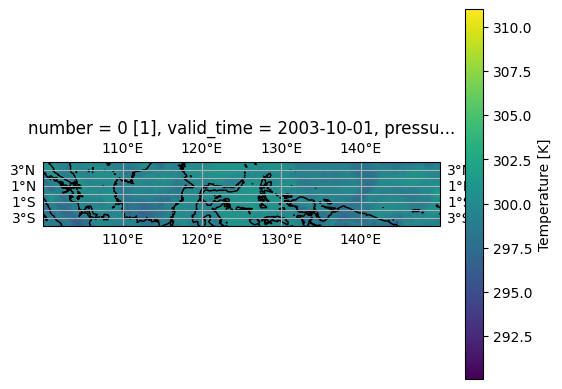

In [8]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
era_test.isel(valid_time=0).t.plot(ax=ax)
ax.coastlines()
#ax.set_extent([-180,180,-90,90])
# maritime boundaries
ax.set_extent([100,150,-4,4])

grid = ax.gridlines(draw_labels=True)

In [9]:

era_test_var = era_test['t'].compute()


lon_wise_dat = []



In [10]:
lon_wise_dat = []

for ii in era_test_var['longitude']:
    selected_data = era_test_var.sel(longitude=ii)
    new_time = selected_data['valid_time'] + pd.Timedelta(ii.values/15,unit='h')
    new_dset = xr.DataArray(selected_data.values,dims=['time','latitude'],coords={'time':new_time.values,
                                                                                         'latitude':selected_data['latitude']})
    
    #new_dset['time'] = new_dset['time']
    
    lon_wise_dat.append(new_dset)


In [11]:
final_dset = xr.combine_nested(lon_wise_dat,concat_dim='longitude')

In [12]:
final_dset_new = final_dset.resample(time='1h').mean()

In [13]:
final_dset_new['longitude'] = era_test_var['longitude']



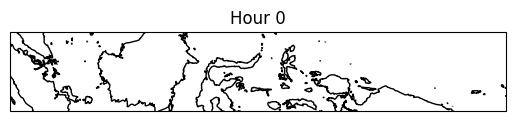

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation

# Assuming final_dset_new is a DataArray or Dataset with a time dimension
# and that it has a method to plot itself on the given axis

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    final_dset_new.isel(time=frame).T.plot(ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.set_title(f"Hour {frame}")
    ax.coastlines()
    ax.set_extent([100,150,-4,4])

# Create the animation
ani = FuncAnimation(fig, update, frames=29, repeat=False)

# Display the animation

from IPython.display import HTML
HTML(ani.to_jshtml())

In [33]:
era_test_var

<xarray.DataArray 't' (valid_time: 744, latitude: 41, longitude: 1169)> Size: 143MB
dask.array<rechunk-merge, shape=(744, 41, 1169), dtype=float32, chunksize=(248, 19, 390), chunktype=numpy.ndarray>
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 6kB 2003-10-01 ... 2003-10-31...
    pressure_level  float64 8B 1e+03
  * latitude        (latitude) float64 328B 5.0 4.75 4.5 ... -4.5 -4.75 -5.0
  * longitude       (longitude) float64 9kB -141.0 -140.8 -140.5 ... 150.8 151.0
    expver          (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/31)
    GRIB_paramId:                             130
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      47929
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Temperature
    units:                                    K
    standard_name:                            air_temperature

In [71]:
import xarray as xr
import pandas as pd

era_test_var = era_test['t']
# Define a function to convert data to longitude-wise solar time (LST)
def convert_to_lst(selected_data):
    new_time = selected_data['valid_time'] + pd.Timedelta(selected_data['longitude'].values / 15, unit='h')
    new_dset = xr.DataArray(
        selected_data.values,
        dims=['valid_time', 'latitude'],
        coords={'valid_time': new_time.values, 'latitude': selected_data['latitude']}
    )
    return new_dset

# Ensure chunks are consistent along the `valid_time` dimension
era_test_var = era_test_var.unify_chunks()

# Apply the conversion function to each longitude slice using map_blocks
lon_wise_dat = []
for ii in era_test_var['longitude']:
    selected_data = era_test_var.sel(longitude=ii)
    result = xr.map_blocks(convert_to_lst, selected_data, template=selected_data)
    lon_wise_dat.append(result)


In [72]:
lon_wise_dat[0].compute()

ValueError: Expected index 'valid_time' to be PandasIndex(DatetimeIndex(['2003-10-01 00:00:00', '2003-10-01 01:00:00',
               '2003-10-01 02:00:00', '2003-10-01 03:00:00',
               '2003-10-01 04:00:00', '2003-10-01 05:00:00',
               '2003-10-01 06:00:00', '2003-10-01 07:00:00',
               '2003-10-01 08:00:00', '2003-10-01 09:00:00',
               ...
               '2003-10-10 22:00:00', '2003-10-10 23:00:00',
               '2003-10-11 00:00:00', '2003-10-11 01:00:00',
               '2003-10-11 02:00:00', '2003-10-11 03:00:00',
               '2003-10-11 04:00:00', '2003-10-11 05:00:00',
               '2003-10-11 06:00:00', '2003-10-11 07:00:00'],
              dtype='datetime64[ns]', name='valid_time', length=248, freq=None)). Received PandasIndex(DatetimeIndex(['2003-09-30 14:36:00', '2003-09-30 15:36:00',
               '2003-09-30 16:36:00', '2003-09-30 17:36:00',
               '2003-09-30 18:36:00', '2003-09-30 19:36:00',
               '2003-09-30 20:36:00', '2003-09-30 21:36:00',
               '2003-09-30 22:36:00', '2003-09-30 23:36:00',
               ...
               '2003-10-10 12:36:00', '2003-10-10 13:36:00',
               '2003-10-10 14:36:00', '2003-10-10 15:36:00',
               '2003-10-10 16:36:00', '2003-10-10 17:36:00',
               '2003-10-10 18:36:00', '2003-10-10 19:36:00',
               '2003-10-10 20:36:00', '2003-10-10 21:36:00'],
              dtype='datetime64[ns]', name='valid_time', length=248, freq=None)) instead.

In [61]:

# Combine the results along the longitude dimension
final_dset = xr.combine_nested(lon_wise_dat, concat_dim='longitude')

# Resample the dataset to hourly means
final_dset_new = final_dset.resample(valid_time='1h').mean()

# Assign the original longitude values back to the dataset
final_dset_new['longitude'] = era_test_var['longitude']

# Output the final dataset
final_dset_new

KeyError: 'valid_time'